# Practice 1: Modeling in vitro cell growth and death processes

Tumor cells growing in-vitro in wells where they are allowed to grow freely in the presence of nutrients, present growth curves like the one in the figure.

<img src="img/im.png">

Several numerical examples are available in the Matlab files 'data/ejemplo1p1.mat' and 'data/ejemplo2p1.mat'
available. The variables that begin with "t" are the times of the measurements in
hours and the others are cellular index measured with an xCELLigence Real-Time Cell Analyzer, which is expected
that is approximately proportional to the number of cells.

# Task
It is requested to adjust a model of tumor growth with death and see if it is able to describe the results.

# Data we have:

Import modules we will use in this Notebook

In [1]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import curve_fit

In [2]:
mat = loadmat('data/ejemplo1.mat')
df_1 = pd.DataFrame()
for i in mat:
    if '__' not in i and 'readme' not in i:
        df_1[i] = pd.Series(mat[i][:,0])
df_1 = df_1.set_index('tH460_4000_B')
df_1.head()

,H460_2000_B,H460_4000_B
tH460_4000_B,,
0.0000,0.0000,0.0000
0.0033,-0.0005,0.0001
1.3417,0.0259,0.0608
1.8419,0.0176,0.0602
2.3422,0.0140,0.0601


In [3]:
mat = loadmat('data/ejemplo2.mat')
df_2 = pd.DataFrame()
for i in mat:
    if '__' not in i and 'readme' not in i:
        df_2[i] = pd.Series(mat[i][:, 0])
df_2 = df_2.set_index('t_2000')
df_2.head()

,SH460_2000
t_2000,
0.0000,0.0000
0.0092,0.0005
1.1411,-0.0554
1.6411,-0.0391
2.1414,-0.0578


Let's plot our data!

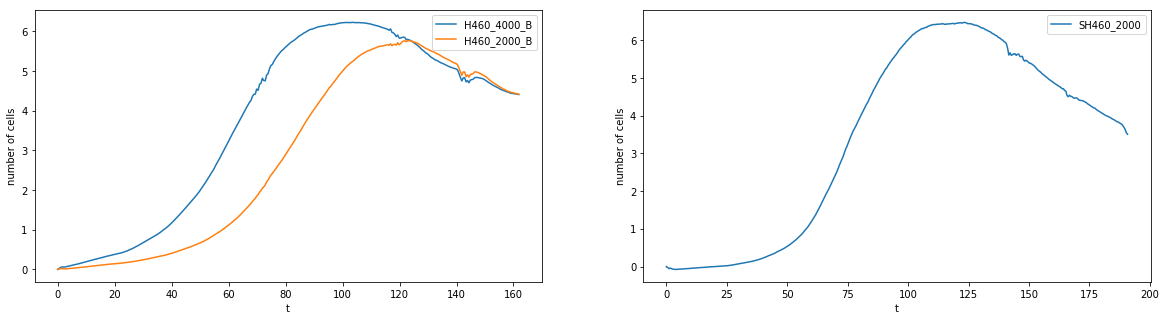

In [4]:
plt.rcParams["figure.figsize"] = (20,5)
plt.subplot(1, 2, 1)
plt.plot(df_1['H460_4000_B'], label='H460_4000_B');
plt.plot(df_1['H460_2000_B'], label='H460_2000_B');
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(df_2['SH460_2000'], label='SH460_2000');
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

Pandas DataFrame type is perfect for tabular information analysis. But for plotting it would convenient to use simple lists:

In [5]:
d_time_1 = df_1.index.values
d_val_1_2000 = df_1['H460_2000_B'].values
d_val_1_4000 = df_1['H460_4000_B'].values
d_time_2 = df_2.index.values
d_val_2 = df_2['SH460_2000'].values

# Models we have:

## 1) Discrete model
$$N_{j+1} = 2 * N_j$$

For uniformity of further model's comparison we will switch to continious analog:
$$N(t) = a b^t$$
It is not adecuate transition to continous case probably(not at each new time moment $t$ we have new generation $j$; probably each generation $j$ lives some time span $[t_{j}, t_{j+1})$). However we will fit this function with parameters $a, b$.

In [6]:
def model_1(t, a, b):
    return a * np.power(b, t)

We will use SciPy's curve_fit function - it returns tuple consisting from 2 parameters. The first of them is a list of optimal parameters for fittting into the data we have provided under our constraints.

In [7]:
popt_1_1, pcov_1_1 = curve_fit(model_1, d_time_1, d_val_1_2000, bounds=(0, [3, 3]))
popt_1_2, pcov_1_2 = curve_fit(model_1, d_time_1, d_val_1_4000, bounds=(0, [3, 3]))
popt_1_3, pcov_1_3 = curve_fit(model_1, d_time_2, d_val_2, bounds=(0, [3, 3]))

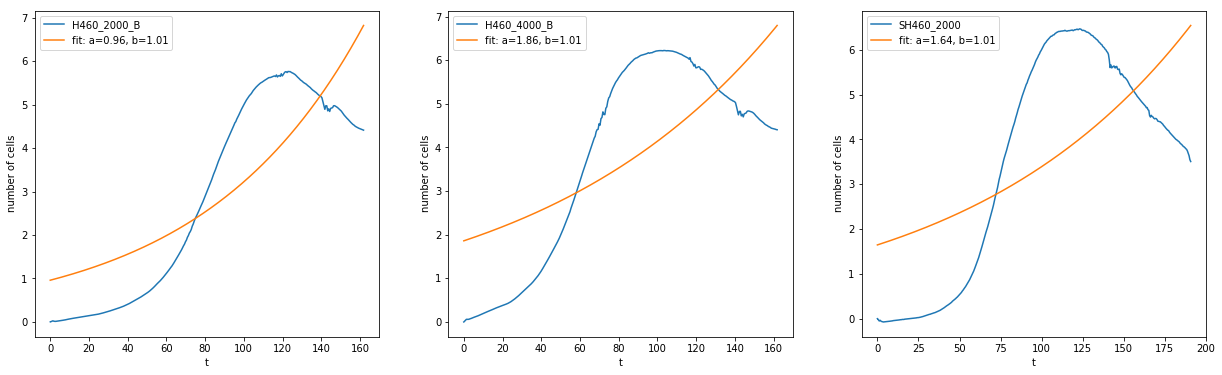

In [8]:
plt.rcParams["figure.figsize"] = (21,6)
plt.subplot(1, 3, 1)
plt.plot(d_time_1, d_val_1_2000, label='H460_2000_B');
plt.plot(d_time_1, model_1(d_time_1, *popt_1_1), label='fit: a={:.2f}, b={:.2f}'.format(popt_1_1[0], popt_1_1[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 2)
plt.plot(d_time_1, d_val_1_4000, label='H460_4000_B');
plt.plot(d_time_1, model_1(d_time_1, *popt_1_2), label='fit: a={:.2f}, b={:.2f}'.format(popt_1_2[0], popt_1_2[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 3)
plt.plot(d_time_2, d_val_2, label='SH460_2000')
plt.plot(d_time_2, model_1(d_time_2, *popt_1_3), label='fit: a={:.2f}, b={:.2f}'.format(popt_1_3[0], popt_1_3[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

In [35]:
def integrate_numerically(x, y):
    res = 0
    for i in range(0, len(x) - 1):
        res += (x[i+1] - x[i]) * y[i+1]
    return res

In [38]:
error_1_1 = np.abs(model_1(d_time_1, *popt_1_1) - d_val_1_2000)
error_1_2 = np.abs(model_1(d_time_1, *popt_1_2) - d_val_1_4000)
error_1_3 = np.abs(model_1(d_time_2, *popt_1_3) - d_val_2)

In [41]:
error_1 = integrate_numerically(d_time_1, error_1_1) + integrate_numerically(d_time_1, error_1_2) + integrate_numerically(d_time_2, error_1_3)
print(error_1)

725.3996323175852


## 2) Continuous model(no saturation)

$$\frac{dN(t)}{dt} = \lambda N(t) = \frac{N(t)}{\tau}$$
$$N(t_0) = N_0$$

$$N(t) = {N(t_0)}exp\Big(\frac{t - t_0}{\tau}\Big)$$

In [9]:
def model_2(t, n0, tau):
    """Model #2 formula"""
    t0 = 0
    return n0 * np.exp((t - t0) / tau)

In [10]:
popt_2_1, pcov_2_1 = curve_fit(model_2, d_time_1, d_val_1_2000, bounds=(0, [100, 1000]))
popt_2_2, pcov_2_2 = curve_fit(model_2, d_time_1, d_val_1_4000, bounds=(0, [100, 1000]))
popt_2_3, pcov_2_3 = curve_fit(model_2, d_time_2, d_val_2, bounds=(0, [100, 1000]))

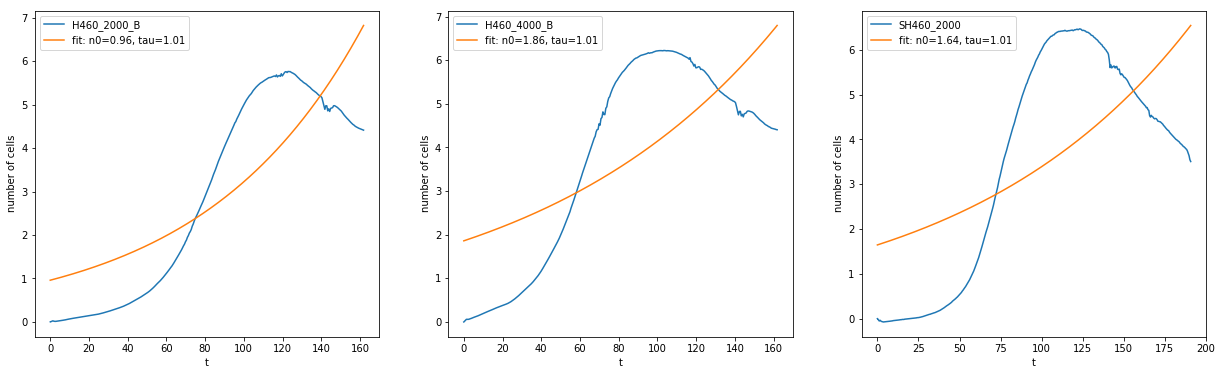

In [11]:
plt.rcParams["figure.figsize"] = (21,6)
plt.subplot(1, 3, 1)
plt.plot(d_time_1, d_val_1_2000, label='H460_2000_B');
plt.plot(d_time_1, model_2(d_time_1, *popt_2_1), label='fit: n0={:.2f}, tau={:.2f}'.format(popt_1_1[0], popt_1_1[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 2)
plt.plot(d_time_1, d_val_1_4000, label='H460_4000_B');
plt.plot(d_time_1, model_2(d_time_1, *popt_2_2), label='fit: n0={:.2f}, tau={:.2f}'.format(popt_1_2[0], popt_1_2[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 3)
plt.plot(d_time_2, d_val_2, label='SH460_2000')
plt.plot(d_time_2, model_2(d_time_2, *popt_2_3), label='fit: n0={:.2f}, tau={:.2f}'.format(popt_1_3[0], popt_1_3[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

To evaluate quality of each method fitting we numerically compute area between approximations and data we fit to.

In [34]:
error_2_1 = np.abs(model_2(d_time_1, *popt_2_1) - d_val_1_2000)
error_2_2 = np.abs(model_2(d_time_1, *popt_2_2) - d_val_1_4000)
error_2_3 = np.abs(model_2(d_time_2, *popt_2_3) - d_val_2)

In [36]:
error_2 = integrate_numerically(d_time_1, error_2_1) + integrate_numerically(d_time_1, error_2_2) + integrate_numerically(d_time_2, error_2_3)
print(error_2)

725.3998729444431


## 3) Logistic equation (model with saturation)

$$\frac{dN}{dt} = \frac{1}{\tau}N\Big(1 - \frac{N}{K}\Big)$$
where $\tau$ ~ Population doubling time, $K = $ Max. cell number
Solution of above equation is:
$$N(t) = \frac{K}{1 + (\frac{K}{N(0)} - 1)exp(-\frac{t}{\tau})}$$

In [14]:
K_MAX = None
def model_3(t, n0, tau):
    """Model 3 formula"""
    K = K_MAX
    return K / (1 + (K / n0 - 1) * np.exp(-t/tau))

We have to define $K$ for each case first (using our data):

In [15]:
K_1 = np.max(d_val_1_2000)
K_2 = np.max(d_val_1_4000)
K_3 = np.max(d_val_2)

In [16]:
K_MAX = K_1
popt_3_1, pcov_3_1 = curve_fit(model_3, d_time_1, d_val_1_2000, bounds=(0, [100, 1000]))
K_MAX = K_2
popt_3_2, pcov_3_2 = curve_fit(model_3, d_time_1, d_val_1_4000, bounds=(0, [100, 1000]))
K_MAX = K_3
popt_3_3, pcov_3_3 = curve_fit(model_3, d_time_2, d_val_2, bounds=(0, [100, 1000]))

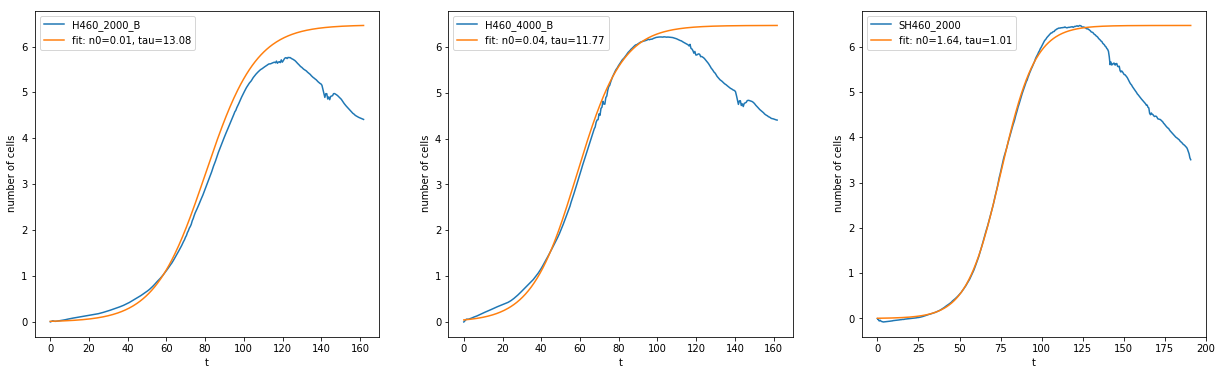

In [17]:
plt.rcParams["figure.figsize"] = (21,6)
plt.subplot(1, 3, 1)
plt.plot(d_time_1, d_val_1_2000, label='H460_2000_B');
plt.plot(d_time_1, model_3(d_time_1, *popt_3_1), label='fit: n0={:.2f}, tau={:.2f}'.format(popt_3_1[0], popt_3_1[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 2)
plt.plot(d_time_1, d_val_1_4000, label='H460_4000_B');
plt.plot(d_time_1, model_3(d_time_1, *popt_3_2), label='fit: n0={:.2f}, tau={:.2f}'.format(popt_3_2[0], popt_3_2[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 3)
plt.plot(d_time_2, d_val_2, label='SH460_2000')
plt.plot(d_time_2, model_3(d_time_2, *popt_3_3), label='fit: n0={:.2f}, tau={:.2f}'.format(popt_1_3[0], popt_1_3[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

In [42]:
error_3_1 = np.abs(model_3(d_time_1, *popt_3_1) - d_val_1_2000)
error_3_2 = np.abs(model_3(d_time_1, *popt_3_2) - d_val_1_4000)
error_3_3 = np.abs(model_3(d_time_2, *popt_3_3) - d_val_2)

In [43]:
error_3 = integrate_numerically(d_time_1, error_3_1) + integrate_numerically(d_time_1, error_3_2) + integrate_numerically(d_time_2, error_3_3)
print(error_3)

195.57670845623784


## 4) Generalized logistics
(Does it satisfy our requirements?) - No, it doesn't.
* $f(t) \approx \frac{t}{\tau}$ only if $\nu > 0$
* $f(t) \rightarrow K, t \rightarrow \infty$ - is not true
$$f(t) = \frac{t}{\tau}\big(1 - {\Big(\frac{t}{K}\Big)}^\nu\big)$$

In [18]:
K_MAX = None
def model_4(t, tau, nu):
    K = K_MAX
    return (t / tau) * (1 - np.power((t / K), nu))

In [19]:
K_MAX = K_1
popt_4_1, pcov_4_1 = curve_fit(model_4, d_time_1, d_val_1_2000, bounds=(0, [100, 20]))
K_MAX = K_2
popt_4_2, pcov_4_2 = curve_fit(model_4, d_time_1, d_val_1_4000, bounds=(0, [100, 20]))
K_MAX = K_3
popt_4_3, pcov_4_3 = curve_fit(model_4, d_time_2, d_val_2, bounds=(0, [100, 20]))

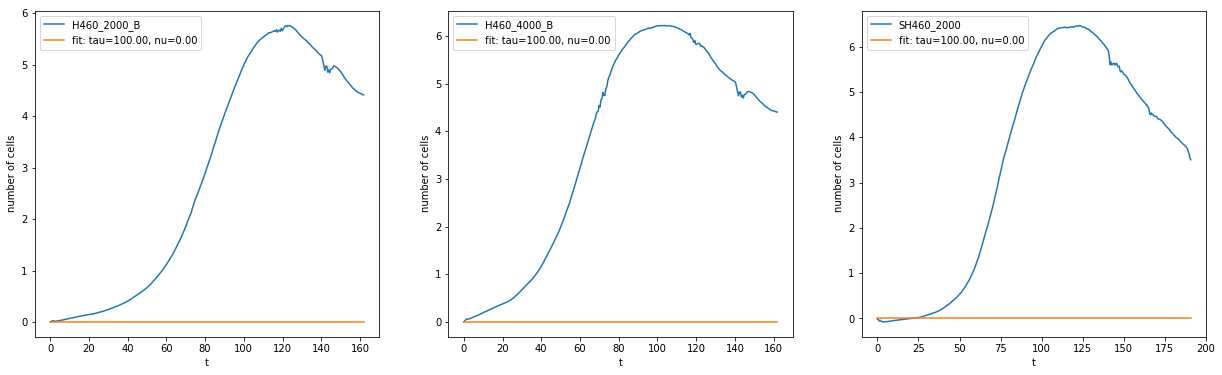

In [20]:
plt.rcParams["figure.figsize"] = (21,6)
plt.subplot(1, 3, 1)
plt.plot(d_time_1, d_val_1_2000, label='H460_2000_B');
plt.plot(d_time_1, model_4(d_time_1, *popt_4_1), label='fit: tau={:.2f}, nu={:.2f}'.format(popt_4_1[0], popt_4_1[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 2)
plt.plot(d_time_1, d_val_1_4000, label='H460_4000_B');
plt.plot(d_time_1, model_4(d_time_1, *popt_4_2), label='fit: tau={:.2f}, nu={:.2f}'.format(popt_4_2[0], popt_4_2[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 3)
plt.plot(d_time_2, d_val_2, label='SH460_2000')
plt.plot(d_time_2, model_4(d_time_2, *popt_4_3), label='fit: tau={:.2f}, nu={:.2f}'.format(popt_4_3[0], popt_4_3[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

In [44]:
error_4_1 = np.abs(model_4(d_time_1, *popt_4_1) - d_val_1_2000)
error_4_2 = np.abs(model_4(d_time_1, *popt_4_2) - d_val_1_4000)
error_4_3 = np.abs(model_4(d_time_2, *popt_4_3) - d_val_2)

In [45]:
error_4 = integrate_numerically(d_time_1, error_4_1) + integrate_numerically(d_time_1, error_4_2) + integrate_numerically(d_time_2, error_4_3)
print(error_4)

1725.5133896100515


## 5) Gompertz
Does it satisfy our requirements?<br>
No, it doesn't satisfy our conditions:<br>
* $f(t) \approx \frac{t}{\tau}, t << K$ is broken ($ f(t) \approx +0$)
* $f(t) \rightarrow K, t \rightarrow \infty$ is broken ($f(t) \rightarrow -\infty$)
$$f(t) = -\frac{t}{\tau}log\Big(\frac{t}{K}\Big)$$

In [21]:
K_MAX = None
def model_5(t, tau):
    K = K_MAX
    return - (t / tau) * np.log(t / K)

In [22]:
K_MAX = K_1
popt_5_1, pcov_5_1 = curve_fit(model_5, d_time_1, d_val_1_2000, bounds=(0, 1000))
K_MAX = K_2
popt_5_2, pcov_5_2 = curve_fit(model_5, d_time_1, d_val_1_4000, bounds=(0, 1000))
K_MAX = K_3
popt_5_3, pcov_5_3 = curve_fit(model_5, d_time_2, d_val_2, bounds=(0, 1000))

/home/anton/.pyenv/versions/miniconda3-4.3.30/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/anton/.pyenv/versions/miniconda3-4.3.30/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


ValueError: Residuals are not finite in the initial point.

## 6) Model with nutrients(resources) limitations
$$
\begin{equation*}
    \begin{cases}
    \frac{dN}{dt} = \frac{N}{\tau}\Big(1 - \frac{N}{K} \Big) - g(R)N
    \\
    \frac{dR}{dt} = -\lambda N
    \end{cases}
\end{equation*}
$$

where $R(t)$ - Resources level, $\lambda$ - resources consumption per cell

$$
\begin{equation*}
    g(R) = 
    \begin{cases}
        0 &\text{, $R \geq R_{*}$}
        \\
        g_0 &\text{, $R < R_{*}$}
    \end{cases}
\end{equation*}
$$

## 7) Power law model I
Surface driven growth model

$$
\frac{dV}{dt} = \alpha V^{\frac{2}{3}}
$$

$$
V(t) = {\big( V_0^{\frac{1}{3}} + \frac{1}{3}\alpha t\big)}^{3}
$$

In [23]:
def model_7(t, v_init, alpha):
    return np.power(np.power(v_init, 1/3) + alpha * t / 3, 3)

In [24]:
popt_7_1, pcov_7_1 = curve_fit(model_7, d_time_1, d_val_1_2000, bounds=(0, [10, 100]))
popt_7_2, pcov_7_2 = curve_fit(model_7, d_time_1, d_val_1_4000, bounds=(0, [10, 100]))
popt_7_3, pcov_7_3 = curve_fit(model_7, d_time_2, d_val_2, bounds=(0, [10, 100]))

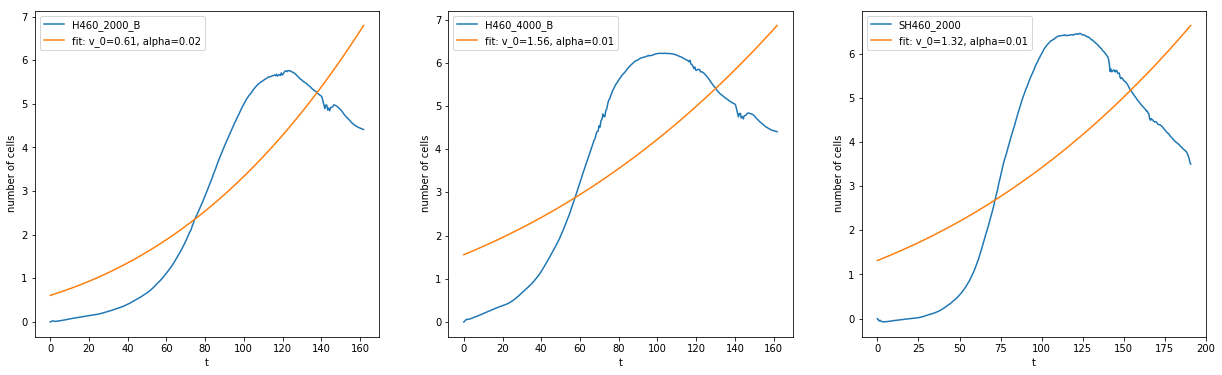

In [25]:
plt.rcParams["figure.figsize"] = (21,6)
plt.subplot(1, 3, 1)
plt.plot(d_time_1, d_val_1_2000, label='H460_2000_B');
plt.plot(d_time_1, model_7(d_time_1, *popt_7_1), label='fit: v_0={:.2f}, alpha={:.2f}'.format(popt_7_1[0], popt_7_1[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 2)
plt.plot(d_time_1, d_val_1_4000, label='H460_4000_B');
plt.plot(d_time_1, model_7(d_time_1, *popt_7_2), label='fit: v_0={:.2f}, alpha={:.2f}'.format(popt_7_2[0], popt_7_2[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 3)
plt.plot(d_time_2, d_val_2, label='SH460_2000')
plt.plot(d_time_2, model_7(d_time_2, *popt_7_3), label='fit: v_0={:.2f}, alpha={:.2f}'.format(popt_7_3[0], popt_7_3[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

In [48]:
error_7_1 = np.abs(model_7(d_time_1, *popt_7_1) - d_val_1_2000)
error_7_2 = np.abs(model_7(d_time_1, *popt_7_2) - d_val_1_4000)
error_7_3 = np.abs(model_7(d_time_2, *popt_7_3) - d_val_2)

In [49]:
error_7 = integrate_numerically(d_time_1, error_7_1) + integrate_numerically(d_time_1, error_7_2) + integrate_numerically(d_time_2, error_7_3)
print(error_7)

678.2035172174667


## 8) Power law model II

$$
\frac{dV}{dt} = a V^{\frac{2}{3}} - b V
$$

$$
V(t) = \big[ \frac{a}{b} + (V_0^{\frac{1}{3}} - \frac{a}{b})e^{-\frac{2 b t}{3}} \big]^3
$$

In [29]:
def model_8(t, v_init, a, b):
    return np.power(a/b + (np.power(v_init, 1/3) - a/b) * np.exp(-2 * b * t / 3), 3)

In [31]:
popt_8_1, pcov_8_1 = curve_fit(model_8, d_time_1, d_val_1_2000, bounds=(0, [10, 100, 100]))
popt_8_2, pcov_8_2 = curve_fit(model_8, d_time_1, d_val_1_4000, bounds=(0, [10, 100, 100]))
popt_8_3, pcov_8_3 = curve_fit(model_8, d_time_2, d_val_2, bounds=(0, [10, 100, 100]))

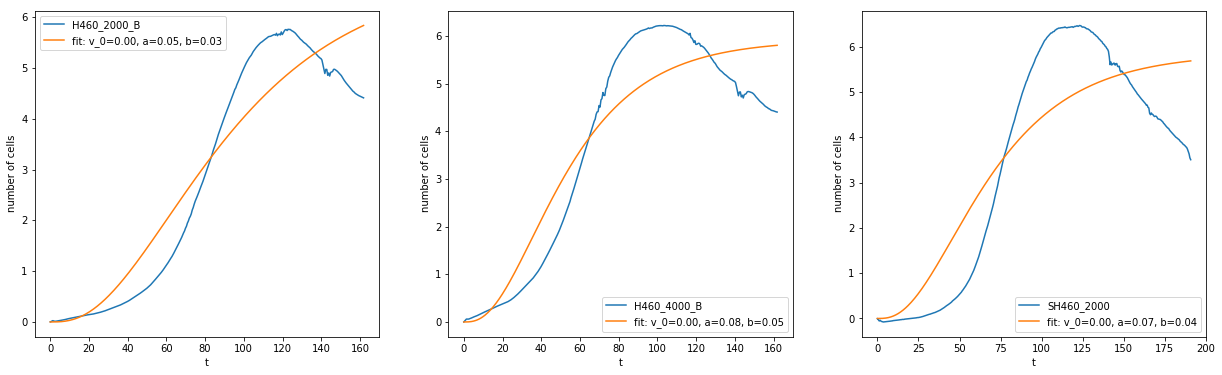

In [32]:
plt.rcParams["figure.figsize"] = (21,6)
plt.subplot(1, 3, 1)
plt.plot(d_time_1, d_val_1_2000, label='H460_2000_B');
plt.plot(d_time_1, model_8(d_time_1, *popt_8_1), label='fit: v_0={:.2f}, a={:.2f}, b={:.2f}'.format(popt_8_1[0], popt_8_1[1], popt_8_1[2]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 2)
plt.plot(d_time_1, d_val_1_4000, label='H460_4000_B');
plt.plot(d_time_1, model_8(d_time_1, *popt_8_2), label='fit: v_0={:.2f}, a={:.2f}, b={:.2f}'.format(popt_8_2[0], popt_8_2[1], popt_8_2[2]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 3)
plt.plot(d_time_2, d_val_2, label='SH460_2000')
plt.plot(d_time_2, model_8(d_time_2, *popt_8_3), label='fit: v_0={:.2f}, a={:.2f}, b={:.2f}'.format(popt_8_3[0], popt_8_3[1], popt_8_3[2]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

In [50]:
error_8_1 = np.abs(model_8(d_time_1, *popt_8_1) - d_val_1_2000)
error_8_2 = np.abs(model_8(d_time_1, *popt_8_2) - d_val_1_4000)
error_8_3 = np.abs(model_8(d_time_2, *popt_8_3) - d_val_2)

In [51]:
error_8 = integrate_numerically(d_time_1, error_8_1) + integrate_numerically(d_time_1, error_8_2) + integrate_numerically(d_time_2, error_8_3)
print(error_8)

385.83874056133754


## 9) Dynamic carrying-capacity model

$$
\begin{equation*}
    \begin{cases}
    \frac{dV}{dt} = \frac{V}{\tau}\Big(1 - \frac{V}{K} \Big)
    \\
    \frac{dK}{dt} = b V^{\frac{2}{3}}
    \end{cases}
\end{equation*}
$$

where $\tau$ - proliferation time, $b$ - geometric factor surface-volume growth

# Conclusions

In [53]:
errors = [error_1, error_2, error_3, error_4, None, None, error_7, error_8]
print("Errors list:")
for idx, value in enumerate(errors):
    print(idx + 1, value)

Errors list:
1 725.3996323175852
2 725.3996323175852
3 195.57670845623784
4 1725.5133896100515
5 None
6 None
7 678.2035172174667
8 385.83874056133754


* Models 5 and 6 were not explored - it will be done
* According to received fitting errors list the best model that was explored is model #3 - *Logistic equation(model with saturation)*
* Curve fitting approach has found the same curves in models 1 and 2
* None of the explored models adequately describes decreasing of the number of the cells

# P. S.
What if...

## 10) Polynomial 2nd degree


$$N(t) = a_0 + a_1 t + a_2 t^2$$

In [54]:
def model_10(t, a0, a1, a2):
    return a0 + a1 * t + a2 * np.power(t, 2)

In [60]:
popt_10_1, pcov_10_1 = curve_fit(model_10, d_time_1, d_val_1_2000)
popt_10_2, pcov_10_2 = curve_fit(model_10, d_time_1, d_val_1_4000)
popt_10_3, pcov_10_3 = curve_fit(model_10, d_time_2, d_val_2)

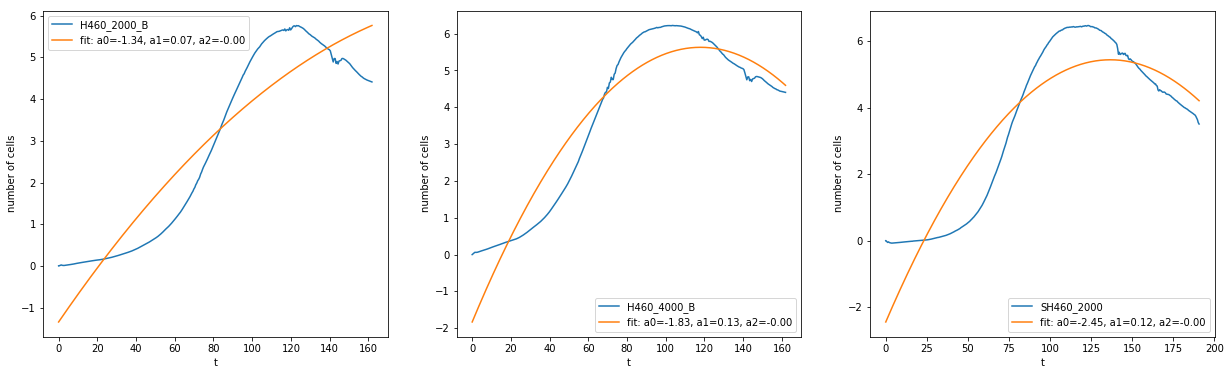

In [56]:
plt.rcParams["figure.figsize"] = (21,6)
plt.subplot(1, 3, 1)
plt.plot(d_time_1, d_val_1_2000, label='H460_2000_B');
plt.plot(d_time_1, model_10(d_time_1, *popt_10_1), label='fit: a0={:.2f}, a1={:.2f}, a2={:.2f}'.format(popt_10_1[0], popt_10_1[1], popt_10_1[2]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 2)
plt.plot(d_time_1, d_val_1_4000, label='H460_4000_B');
plt.plot(d_time_1, model_10(d_time_1, *popt_10_2), label='fit: a0={:.2f}, a1={:.2f}, a2={:.2f}'.format(popt_10_2[0], popt_10_2[1], popt_10_2[2]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 3)
plt.plot(d_time_2, d_val_2, label='SH460_2000')
plt.plot(d_time_2, model_10(d_time_2, *popt_10_3), label='fit: a0={:.2f}, a1={:.2f}, a2={:.2f}'.format(popt_10_3[0], popt_10_3[1], popt_10_3[2]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

In [66]:
error_10_1 = np.abs(model_10(d_time_1, *popt_10_1) - d_val_1_2000)
error_10_2 = np.abs(model_10(d_time_1, *popt_10_2) - d_val_1_4000)
error_10_3 = np.abs(model_10(d_time_2, *popt_10_3) - d_val_2)
error_10 = integrate_numerically(d_time_1, error_10_1) + integrate_numerically(d_time_1, error_10_2) + integrate_numerically(d_time_2, error_10_3)
print(error_10)

381.6199171359475


## 11) Polynomial 5th degree

$$N(t) = a_0 + a_1 t + a_2 t^2 + a_3 t^3 + a_4 t^4 + a_5 t^5$$

In [58]:
def model_11(t, a0, a1, a2, a3, a4, a5):
    return a0 + a1 * t + a2 * np.power(t, 2) + a3 * np.power(t, 3) + a4 * np.power(t, 4) + a5 * np.power(t, 5)

In [59]:
popt_11_1, pcov_11_1 = curve_fit(model_11, d_time_1, d_val_1_2000)
popt_11_2, pcov_11_2 = curve_fit(model_11, d_time_1, d_val_1_4000)
popt_11_3, pcov_11_3 = curve_fit(model_11, d_time_2, d_val_2)

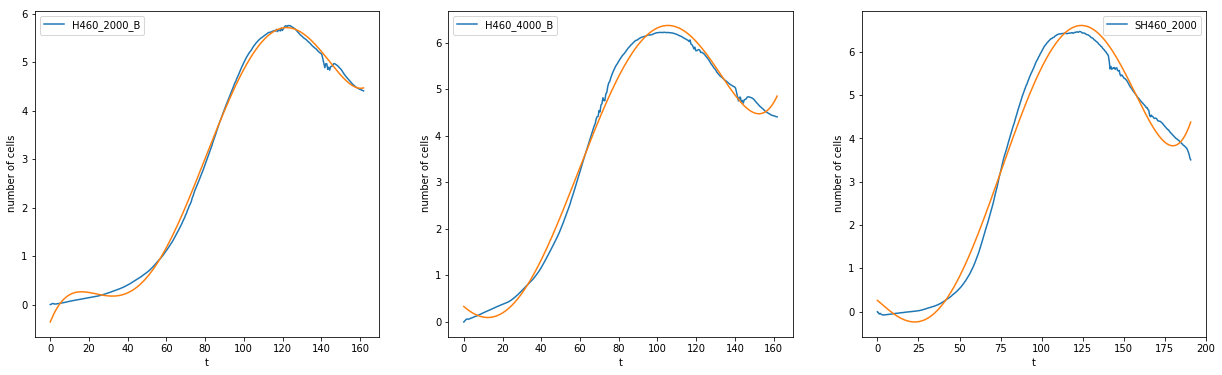

In [63]:
plt.rcParams["figure.figsize"] = (21,6)
plt.subplot(1, 3, 1)
plt.plot(d_time_1, d_val_1_2000, label='H460_2000_B');
plt.plot(d_time_1, model_11(d_time_1, *popt_11_1))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 2)
plt.plot(d_time_1, d_val_1_4000, label='H460_4000_B');
plt.plot(d_time_1, model_11(d_time_1, *popt_11_2))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 3)
plt.plot(d_time_2, d_val_2, label='SH460_2000')
plt.plot(d_time_2, model_11(d_time_2, *popt_11_3))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

In [67]:
error_11_1 = np.abs(model_11(d_time_1, *popt_11_1) - d_val_1_2000)
error_11_2 = np.abs(model_11(d_time_1, *popt_11_2) - d_val_1_4000)
error_11_3 = np.abs(model_11(d_time_2, *popt_11_3) - d_val_2)
error_11 = integrate_numerically(d_time_1, error_11_1) + integrate_numerically(d_time_1, error_11_2) + integrate_numerically(d_time_2, error_11_3)
print(error_11)

82.13766225225052
